In [1]:
!pip install -r requirements.txt --quiet

In [2]:
import gspread
import time

# establish connection with service account
service_account = gspread.service_account(filename = "service_account.json")
# open the google sheet with service account instance stored in local machine / cloud
google_sheet = service_account.open("stocks_sheet")
# access the main work sheet to access the data
work_sheet = google_sheet.worksheet("Sheet1")
# clear the sheet data
work_sheet.clear()
# prepare the query
stock_name = "NSE:TCS"
start_date = "DATE(2019, 1, 1)" # YYYY-MM-DD
end_date = "DATE(2023, 1, 1)"
interval = "DAILY"
attribute = "all"
# GOOGLEFINANCE("NASDAQ:GOOG", "price", DATE(2014,1,1), DATE(2014,12,31), "DAILY")
g_finance_query = f'=GOOGLEFINANCE("{stock_name}", "{attribute}", {start_date}, {end_date}, "{interval}")'
# run the google finance query
work_sheet.update('A1', g_finance_query, raw=False)
time.sleep( 5 )
stock_records = work_sheet.get_all_records()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

stock_prices_df = pd.DataFrame(stock_records)
stock_prices_df.head()

,Date,Open,High,Low,Close,Volume
0,1/2/2019 15:30:00,1905.0,1934.45,1900.0,1923.30,2100463
1,1/3/2019 15:30:00,1919.0,1944.95,1893.1,1899.95,2611668
2,1/4/2019 15:30:00,1900.0,1901.20,1841.0,1876.85,4280862
3,1/7/2019 15:30:00,1891.8,1908.80,1881.0,1897.90,1856423
4,1/8/2019 15:30:00,1905.4,1906.40,1883.3,1893.55,1691756


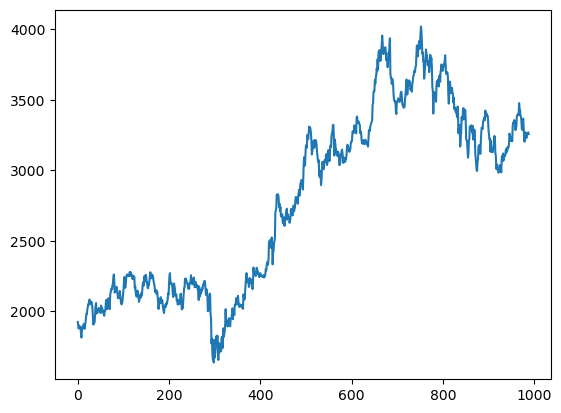

In [4]:
timeseries = stock_prices_df[['Close']].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [5]:
# train - test split for time series

train_size = int(len(timeseries)*0.65)
test_size = len(timeseries) - train_size

train_data, test_data = timeseries[: train_size], timeseries[train_size:]

In [6]:
import torch

def create_dataset(dataset, lookback) : 
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback) : 
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [7]:
lookback = 1

X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(test_data, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([641, 1, 1]) torch.Size([641, 1, 1])
torch.Size([346, 1, 1]) torch.Size([346, 1, 1])


/tmp/ipykernel_84/1174004132.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X), torch.tensor(y)


In [8]:
# build LSTM model
import torch.nn as nn

class StocksModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x) :
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [9]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = StocksModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size = 8)

n_epochs = 2000
for epoch in range(n_epochs) : 
    model.train()
    for X_batch, y_batch in loader :
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #validation
    if epoch % 100 != 0 :
        continue
    model.eval()
    with torch.no_grad() : 
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print('Epoch %d: train RMSE %.4f test RMSE %.df'%(epoch, train_rmse, test_rmse))
        

Epoch 0: train RMSE 2454.8894 test RMSE 3474f
Epoch 100: train RMSE 2356.5007 test RMSE 3374f
Epoch 200: train RMSE 2258.8555 test RMSE 3275f
Epoch 300: train RMSE 2161.4219 test RMSE 3175f
Epoch 400: train RMSE 2064.2791 test RMSE 3076f
Epoch 500: train RMSE 1967.4418 test RMSE 2977f
Epoch 600: train RMSE 1870.9811 test RMSE 2877f
Epoch 700: train RMSE 1774.9406 test RMSE 2778f
Epoch 800: train RMSE 1679.3818 test RMSE 2679f
Epoch 900: train RMSE 1584.4100 test RMSE 2581f
Epoch 1000: train RMSE 1490.0670 test RMSE 2482f
Epoch 1100: train RMSE 1396.6379 test RMSE 2384f
Epoch 1200: train RMSE 1304.1613 test RMSE 2285f
Epoch 1300: train RMSE 1212.8851 test RMSE 2188f
Epoch 1400: train RMSE 1123.1005 test RMSE 2090f
Epoch 1500: train RMSE 1035.1698 test RMSE 1993f
Epoch 1600: train RMSE 949.6115 test RMSE 1896f
Epoch 1700: train RMSE 867.0838 test RMSE 1800f
Epoch 1800: train RMSE 788.5338 test RMSE 1706f
Epoch 1900: train RMSE 715.1553 test RMSE 1612f


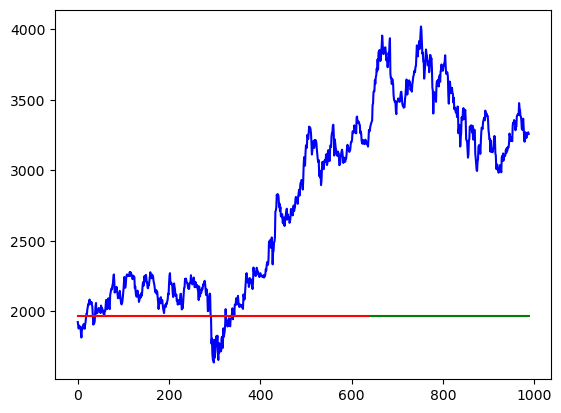

In [10]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

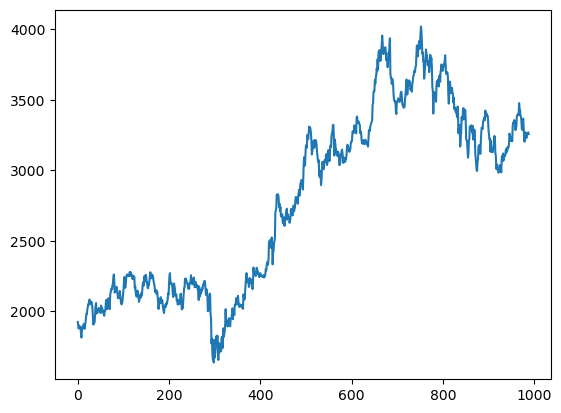

In [11]:
timeseries = stock_prices_df[['Close']].values.astype('float32')
plt.plot(timeseries)
plt.show()